# MobileViT (Modified)

**Reference:** https://github.com/keras-team/keras-io/blob/master/examples/vision/ipynb/mobilevit.ipynb
**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Description:** MobileViT for image classification with combined benefits of convolutions and Transformers.

**Modifier:** Pruetikorn Chirattitikarn<br>
**Date Created:** 08/07/2022<br>
**Last Modified:** 22/07/2022<br>

## Imports

In [1]:
import tensorflow as tf
import sys

from keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow import keras

import tensorflow_datasets as tfds

from datetime import datetime

In [2]:
print("Python version: {}\n".format(sys.version))

print("TensorFlow version:", tf.__version__)
device_name = tf.test.gpu_device_name()
if not device_name:
    raise SystemError("GPU not found")
print("Found GPU at:", device_name)

tfds.disable_progress_bar()

Python version: 3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]

TensorFlow version: 2.6.0
Found GPU at: /device:GPU:0


## Hyperparameters

In [3]:
# Values are from table 4.
patch_size = 4  # 2x2, for the Transformer blocks.
image_size = 256
expansion_factor = 2 # expansion factor for the MobileNetV2 blocks.

## MobileViT Utilities

In [4]:

def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=imagenet_utils.correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m


# Reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features


## MobileViT Function

In [5]:

def create_mobilevit(num_classes=6):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


mobilevit_xxs = create_mobilevit()
mobilevit_xxs.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 512         conv2d[0][0]                     
______________________________________________________________________________________________

## Data Preparation

In [6]:
batch_size = 64
auto = tf.data.AUTOTUNE
resize_bigger = 280
num_classes = 5


def preprocess_dataset(is_training=True):
    def _pp(image, label):
        if is_training:
            # Resize to a bigger spatial resolution and take the random
            # crops.
            #image = tf.image.resize(image, (resize_bigger, resize_bigger))
            #image = tf.image.random_crop(image, [image_size, image_size, 3])
            image = tf.image.resize(image, (image_size, image_size))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (image_size, image_size))
        label = tf.one_hot(label, depth=num_classes)
        return image, label

    return _pp


def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=auto)
    return dataset.batch(batch_size).prefetch(auto)

In [ ]:
# Download flower images from tensorflow-datasets
train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)

num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

In [ ]:
train_dataset = prepare_dataset(train_dataset, is_training=True)
val_dataset = prepare_dataset(val_dataset, is_training=False)

In [7]:
# Download road images from local directory (New Version)
data_train_dir = '/Users/CV/Desktop/UNO-main/datasets/RDD_new/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

data_val_dir = '/Users/CV/Desktop/UNO-main/datasets/RDD_new/val'
val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_val_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 29567 files belonging to 5 classes.
Found 4467 files belonging to 5 classes.


In [8]:
class_names = train_dataset.class_names
print(class_names)

['D00', 'D10', 'D20', 'D40', 'D44']


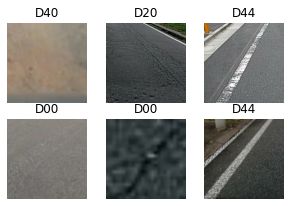

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
val_dataset = val_dataset.map(preprocess_dataset(is_training = True), num_parallel_calls=auto)

train_dataset = train_dataset.shuffle(batch_size * 10)
train_dataset = train_dataset.map(preprocess_dataset(is_training = True), num_parallel_calls=auto)

In [11]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64, 5)


## Training Model

In [12]:
import shutil
shutil.rmtree("./logs")

In [13]:
# Experiment 1 
learning_rate = 0.0001
label_smoothing_factor = 0.1
epochs = 30

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing_factor)


def run_experiment1(epochs=epochs):
    mobilevit_xxs = create_mobilevit(num_classes=num_classes)
    mobilevit_xxs.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

#     checkpoint_filepath = "/tmp/checkpoint"
#     checkpoint_callback = keras.callbacks.ModelCheckpoint(
#         checkpoint_filepath,
#         monitor="val_accuracy",
#         save_best_only=True,
#         save_weights_only=True,
#     )

    logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = logs, 
        histogram_freq = 1, 
        profile_batch = '5000,5020'
    )

    mobilevit_xxs.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[tboard_callback],
    )
#     mobilevit_xxs.load_weights(checkpoint_filepath)
    _, accuracy = mobilevit_xxs.evaluate(val_dataset)
    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")
    return mobilevit_xxs


mobilevit_xxs = run_experiment1()

# Serialize the model as a SavedModel.
mobilevit_xxs.save("Models/modified")

C:\Users\CV\anaconda3\envs\tf01\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/30
462/462 [==============================] - 211s 408ms/step - loss: 1.1847 - accuracy: 0.5678 - val_loss: 2.0240 - val_accuracy: 0.1724
Epoch 2/30
462/462 [==============================] - 194s 404ms/step - loss: 1.0321 - accuracy: 0.6587 - val_loss: 0.9440 - val_accuracy: 0.7101
Epoch 3/30
462/462 [==============================] - 195s 405ms/step - loss: 0.9453 - accuracy: 0.7117 - val_loss: 0.8892 - val_accuracy: 0.7482
Epoch 4/30
462/462 [==============================] - 196s 406ms/step - loss: 0.8984 - accuracy: 0.7378 - val_loss: 0.8581 - val_accuracy: 0.7571
Epoch 5/30
462/462 [==============================] - 195s 405ms/step - loss: 0.8648 - accuracy: 0.7585 - val_loss: 0.8596 - val_accuracy: 0.7632
Epoch 6/30
462/462 [==============================] - 194s 402ms/step - loss: 0.8348 - accuracy: 0.7759 - val_loss: 0.8457 - val_accuracy: 0.7674
Epoch 7/30
462/462 [==============================] - 195s 406ms/step - loss: 0.8089 - accuracy: 0.7881 - val_loss: 0.7801 -

INFO:tensorflow:Assets written to: Models/modified\assets


INFO:tensorflow:Assets written to: Models/modified\assets
C:\Users\CV\anaconda3\envs\tf01\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Result and Optimization

In [ ]:
!pip install -U tensorboard_plugin_profile

In [14]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir="./logs/20220725-131115"

## Conversion to TFLite

In [ ]:
# Convert to TFLite. This form of quantization is called
# post-training dynamic-range quantization in TFLite.
converter = tf.lite.TFLiteConverter.from_saved_model("Models/mobilevit_xxs")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS,  # Enable TensorFlow ops.
]
tflite_model = converter.convert()
open("Models/mobilevit_xxs.tflite", "wb").write(tflite_model)